In [1]:
import logging

import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft

import mkidgen3 as g3
import mkidgen3.plotting

import xrfdc
# This currently requires patching some stuff by hand
xrfdc.DEBUG_MODE = False

In [2]:
# Download Overlay, Optionally Configure Clocks
bitstream = '/home/xilinx/gen3_top_wrapper.bit'

ol = g3.configure(bitstream, ignore_version=True, clocks=True, programming_key = '4.096GSPS_MTS', mts=False)

# Play Waveform

In [3]:
#Set tones to send (in Hz). Domain is [-2047,2048) MHz. Set the SNR for a noise floor, `'max'` will turn off noise.
tones = np.array([250e6])
amplitudes = np.ones_like(tones)/tones.shape[0]*0.5
g3.set_waveform(tones,amplitudes,fpgen='simple')

{'iq': array([-0.3613961 +0.34553272j, -0.46443114+0.18521266j,
        -0.49999595-0.00201416j, ...,  0.16799273+0.4709336j ,
        -0.02041626+0.499583j  , -0.20585927+0.45565552j], dtype=complex64),
 'frequencies': array([2.5e+08]),
 'phases': array([2.37863059])}

# ADC CAPTURE

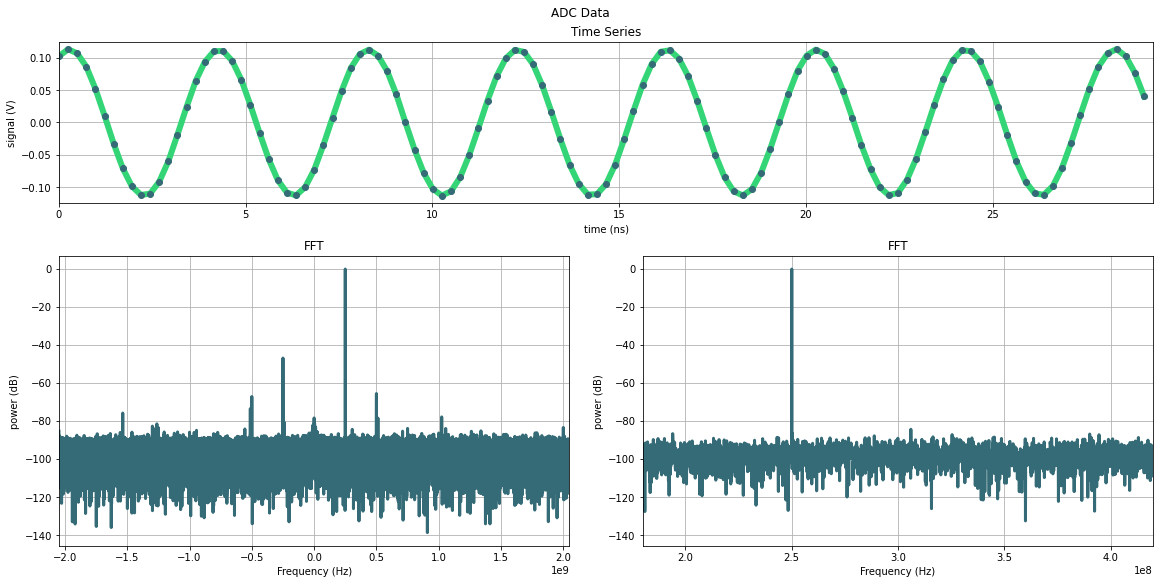

In [4]:
# Trigger Capture
adc_capture_data = ol.capture.capture_adc(2**19, complex=True) # throw away capture to clear any startup garbage

#adc_capture_data = ol.capture.capture_adc(2**19, complex=True)
adc_capture_data/=2**16  #Normalize to 1/2 V
# Plot ADC Data
timerange = (0,120)  # ns
fftrange= (16, 16 + 20*4096) 
fftzoom = (1.8e8, 4.2e8)
mkidgen3.plotting.adc_test_plot(adc_capture_data, timerange, fftrange, fftzoom)

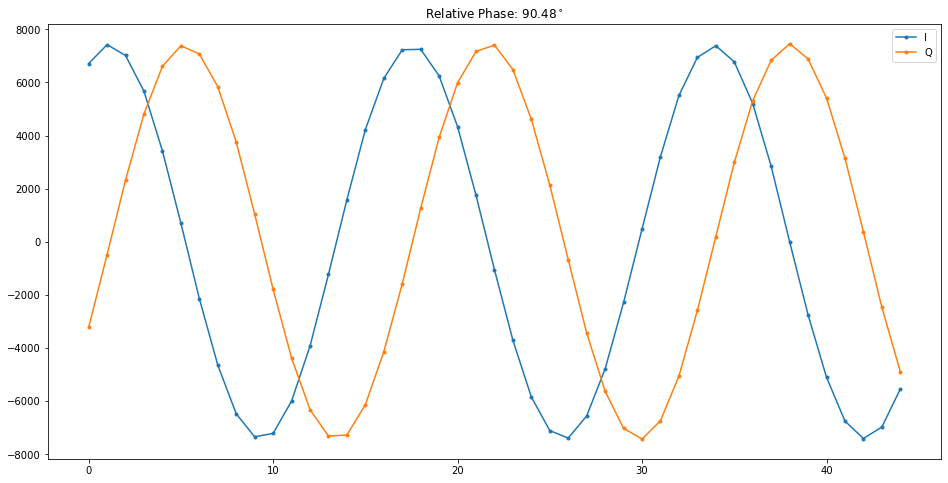

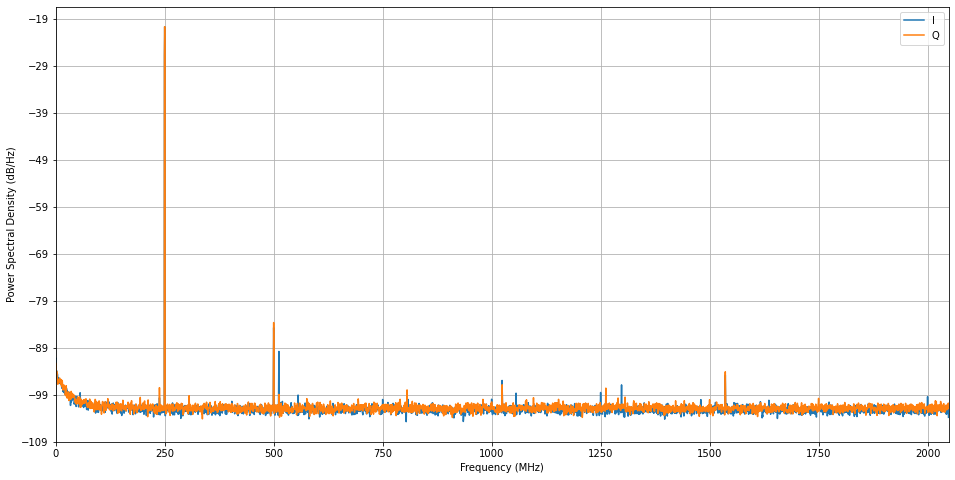

In [5]:
ifft = np.fft.rfft(adc_capture_data.real)
qfft = np.fft.rfft(adc_capture_data.imag)

im = np.argmax(np.abs(ifft))
qm = np.argmax(np.abs(qfft))

rel_phase = np.degrees(np.angle(ifft[im]) - np.angle(qfft[qm]))
rel_phase %= 180.0

plt.figure(figsize=(16,8))
plt.plot(adc_capture_data.real[:45]*2**16, '.-', label="I")
plt.plot(adc_capture_data.imag[:45]*2**16, '.-', label="Q")
plt.title('Relative Phase: ${:.2f}^\circ$'.format(rel_phase))
plt.legend()

plt.figure(figsize=(16, 8))
plt.psd(adc_capture_data.real, label="I", Fs = 4.096e3, NFFT = 8192)
plt.psd(adc_capture_data.imag, label="Q", Fs = 4.096e3, NFFT = 8192)
plt.xlabel('Frequency (MHz)')
plt.xlim(0, 4.096e3/2)
plt.legend()